In [27]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from torch import nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.set_default_dtype(torch.float64)
%config InlineBackend.figure_format='retina'

In [28]:
from modules import Post

In [29]:
from cycler import cycler
from enum import IntEnum

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
plt.rc('text.latex', preamble=r"\usepackage{amsmath} \everymath{\bf}")

default_cycler = cycler(
        color=['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    ) + cycler(
        marker=['.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
    )
plt.rc('axes', prop_cycle=default_cycler)

class Color(IntEnum):
    BLUE = 0
    RED = 1
    GREEN = 2
    ORANGE = 3
    PURPLE = 4
    BROWN = 5
    PINK = 6
    GRAY = 7
    OLIVE = 8
    CYAN = 9

In [30]:
class EM(nn.Module):
    def __init__(self, WM_n_taus, n_features, M_model):
        super(EM, self).__init__()

        self.WM_n_taus = WM_n_taus
        self.n_features = n_features
        self.M_model = M_model

    def forward(self, fs, til_fs, M, M_F, A):
        #     fs.shape: (seq_len, n_features)
        # til_fs.shape: (seq_len, n_features, n_taus)
        #      A.shape: (n_taus, n_features, n_features)   # attention window
        #      M.shape: (n_taus, n_features, n_features)
        #    M_F.shape: (n_taus * n_features * n_features, M_n_s)
        #
        #        Ms.shape: (seq_len, n_taus, n_features, n_features)
        #     til_M.shape: (M_n_taus, n_taus, n_features, n_features)
        
        assert A.dim() == 3

        if M is None:
            M = fs.new_zeros((self.WM_n_taus, self.n_features, self.n_features))
        
        # update M
        for (f, til_f) in zip(fs, til_fs):  # iterate over sequence dim
            dM = torch.einsum("tba, b, at -> tba", (A, f, til_f))
            M = M + dM
        
            # flatten non-sequence dimensions
            M_flat = rearrange(
                dM, 
                'WM_n_tau n_feat_post n_feat_pre -> 1 1 (WM_n_tau n_feat_post n_feat_pre)', 
                WM_n_tau=self.WM_n_taus, 
                n_feat_post=self.n_features, 
                n_feat_pre=self.n_features
            )

            # update log-spaced history of M
            til_Ms, M_F = self.M_model(M_flat, M_F, alphas=None)

            # unflatten
            til_M = til_Ms[:, 0]  # remove seq dim
            til_M = rearrange(
                til_M, 
                '1 (WM_n_tau n_feat_post n_feat_pre) M_n_tau -> M_n_tau WM_n_tau n_feat_post n_feat_pre', 
                WM_n_tau=self.WM_n_taus,
                n_feat_post=self.n_features,
                n_feat_pre=self.n_features,
                M_n_tau=self.M_model.n_taus
            )
        
            self.til_M = til_M
            # self.Ms = Ms

        return M, M_F

    def get_P(self, M, f):
        # M.shape: (seq_len, n_taus, n_features, n_features)
        # f.shape: (seq_len, n_features)
        # returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, za -> ztb", (M, f))

    def get_til_f_bar(self, M, f):
        # M.shape: (seq_len, n_taus, n_features, n_features)
        # f.shape: (seq_len, n_features)
        # returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, zb -> zta", (M, f))

    def get_P_til_f(self, M, til_f):
        #     M.shape: (seq_len, n_taus, n_features, n_features)
        # til_f.shape: (seq_len, n_features, n_taus)
        #     returns: (seq_len, n_taus, n_features)
        assert M.dim() == 4
        return torch.einsum("ztba, zat -> ztb", (M, til_f))

    def get_P_delta(self, M, delta_til_f):
        #     M.shape: (n_taus_pre, n_features_post, n_features_pre)
        # til_f.shape: (delta, n_features_pre, n_taus_pre)
        #     returns: (delta, n_taus_pre, n_features_post)
        assert M.dim() == 3
        M = M.unsqueeze(0).expand(delta_til_f.size()[0],-1,-1,-1)
        return torch.einsum("ztba, zat -> ztb", (M, delta_til_f))
    
    def get_P_delta_sum(self, M, delta_til_f):
        #           M.shape: (n_taus, n_features_post, n_features_pre)
        # delta_til_f.shape: (delta, n_features_pre, n_taus_pre)
        #           returns: (n_features_post, delta)
        assert M.dim() == 3
        M = M.unsqueeze(0).expand(delta_til_f.size()[0],-1,-1,-1)
        return torch.einsum("dtba, dat -> bd", (M, delta_til_f))

    def extra_repr(self):
        return f"n_taus={self.n_taus}, n_features={self.n_features}, M_model={self.M_model}"

In [31]:
def plot_figure(t, inputs, til_f, P_delta_sum, x_tstr, rewind_secs, save_path, ortho=True):
    no_pred = P_delta_sum is None

    dt = 0.01

    Nt = inputs.shape[0]
    x = np.linspace(0, Nt, Nt, endpoint=False)

    fig, axs = plt.subplots(
        nrows=2, 
        figsize=(7, 4), 
        dpi=200, 
        facecolor='w', 
        edgecolor='k', 
        sharex=False, 
        gridspec_kw={'height_ratios': [1, 4]},
        # constrained_layout=True
    )

    n_features = inputs.shape[1]

    # inputs
    for i in range(n_features):
        if ortho:
            shift = 0
        else:
            shift = i * 5 * dt  # for non-orthogonal inputs
        axs[0].fill_between((x[:t]-t)*dt+shift, inputs[:t,i], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    # axs[0].fill_between((x[:t]-t)*dt, inputs[:t,:])
    # axs[0].plot((x[:t]-t)*dt, inputs[:t,:], "-", zorder=0)
    if not no_pred:
        if rewind_secs > 0:
            text = r"$\widetilde{M}$"
        else:
            text = r"$M$"
        axs[0].axvline(-rewind_secs*dt, color="k", linestyle='--')
        axs[0].annotate(text, xy={-rewind_secs*dt,1}, 
                        xytext=(-rewind_secs*dt,2), textcoords='data', ha="center", fontsize=14,
                        arrowprops=dict(facecolor='black'))

    if no_pred:
        axs[0].set_xlim(-300*dt,0)
    else:
        axs[0].set_xlim(-900*dt,250*dt)
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel("$t$", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].set_ylabel("$f$", fontsize=20, rotation=0, labelpad=15, va="center")
    axs[0].set_yticks([])
    axs[0].grid(axis="x")

    # memory
    for i in range(n_features):
        if torch.count_nonzero(til_f[i]) > 0:
            axs[1].plot(-x_tstr*dt, til_f[i], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    axs[1].axvline(x=0, lw=2, color='k')
    axs[1].grid(axis="x")

    if no_pred:
        axs[1].set_xlim(-300*dt,0)
    else:
        axs[1].set_xlim(-900*dt,250*dt)
    axs[1].set_xlabel(r"$\overset{\ast}{\tau}$", fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[1].set_ylabel(r"$\tilde{f}$", fontsize=20, rotation=0, labelpad=15, va="center")
    axs[1].set_yticks([])
    axs[1].set_ylim(bottom=0)

    # prediction
    if not no_pred:
        ax1_twin = axs[1].twinx()

        ax1_twin.plot(x_tstr[:]*dt, P_delta_sum.T[:])  # ".-"

        ax1_twin.set_ylabel(r"$p_\delta$", fontsize=20, rotation=0, labelpad=15, va="center")
        ax1_twin.set_yticks([])
        ax1_twin.set_ylim(bottom=0)

    fig.tight_layout()

    path = Path(save_path)
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=300, bbox_inches='tight')

In [32]:
# ORTHOGONAL
savefile_suffix = ""  # blank

Nt = 1000       # Number of time points
n_features = 5  # Number of features (colors)

inputs = torch.zeros(Nt, n_features)  # (time, feat)

inputs[ 40: 50, Color.GREEN] = 1   # G
inputs[ 80: 90, Color.RED] = 1     # R
inputs[120:130, Color.ORANGE] = 1  # O

inputs[440:450, Color.GREEN] = 1   # G
inputs[481:491, Color.BLUE] = 1    # B
inputs[522:532, Color.PURPLE] = 1  # P

inputs[840:850, Color.GREEN] = 1     # G
# inputs[880:890, Color.RED] = 1     # R
# inputs[920:930, Color.ORANGE] = 1  # O

inputs = inputs.unsqueeze(0)  # add batch dimension

In [33]:
# Working Memory
WM_model = Post(
    tau_min=5,      # Peak time of the first node in the reconstruction
    tau_max=300,    # Peak time of the last node in the reconstruction
    n_taus=50,       # Number of nodes in the reconstruction (the inverse Laplace transform (tilde{f}) of the input)
    k=16,            # Order of the derivative in inverse Laplace transform, larger k causes more narrow peaks in tilde{f}
    g=0,             # Amplitude scaling of nodes in tilde{f}: g=1->equal amplitude, g=0->power-law decay of amplitude)
    batch_first=True,
)
F = None

# Episodic Memory
M_model = Post(
    tau_min=10,         # Peak time of the first node in the reconstruction
    tau_max=60*60*100,  # Peak time of the last node in the reconstruction
    n_taus=200,         # Number of nodes in the reconstruction (the inverse Laplace transform (tilde{f}) of the input))
    k=12,               # Order of the derivative in inverse Laplace transform, larger k causes more narrow peaks in tilde{f}
    g=1,                # Amplitude scaling of nodes in tilde{f}: g=1->equal amplitude, g=0->power-law decay of amplitude)
    batch_first=True,
)
M_F = None

EM_model = EM(WM_n_taus=WM_model.n_taus, n_features=n_features, M_model=M_model)
M = None

In [34]:
lambdas = torch.ones(WM_model.n_taus, n_features, n_features)  # (taus, past, future)
# lambdas[:, :, 0] = 0    # disable blue past (blue cannot generate predictions)
lambdas[:, Color.GREEN, :] = 0    # disable green future (green cannot be predicted)


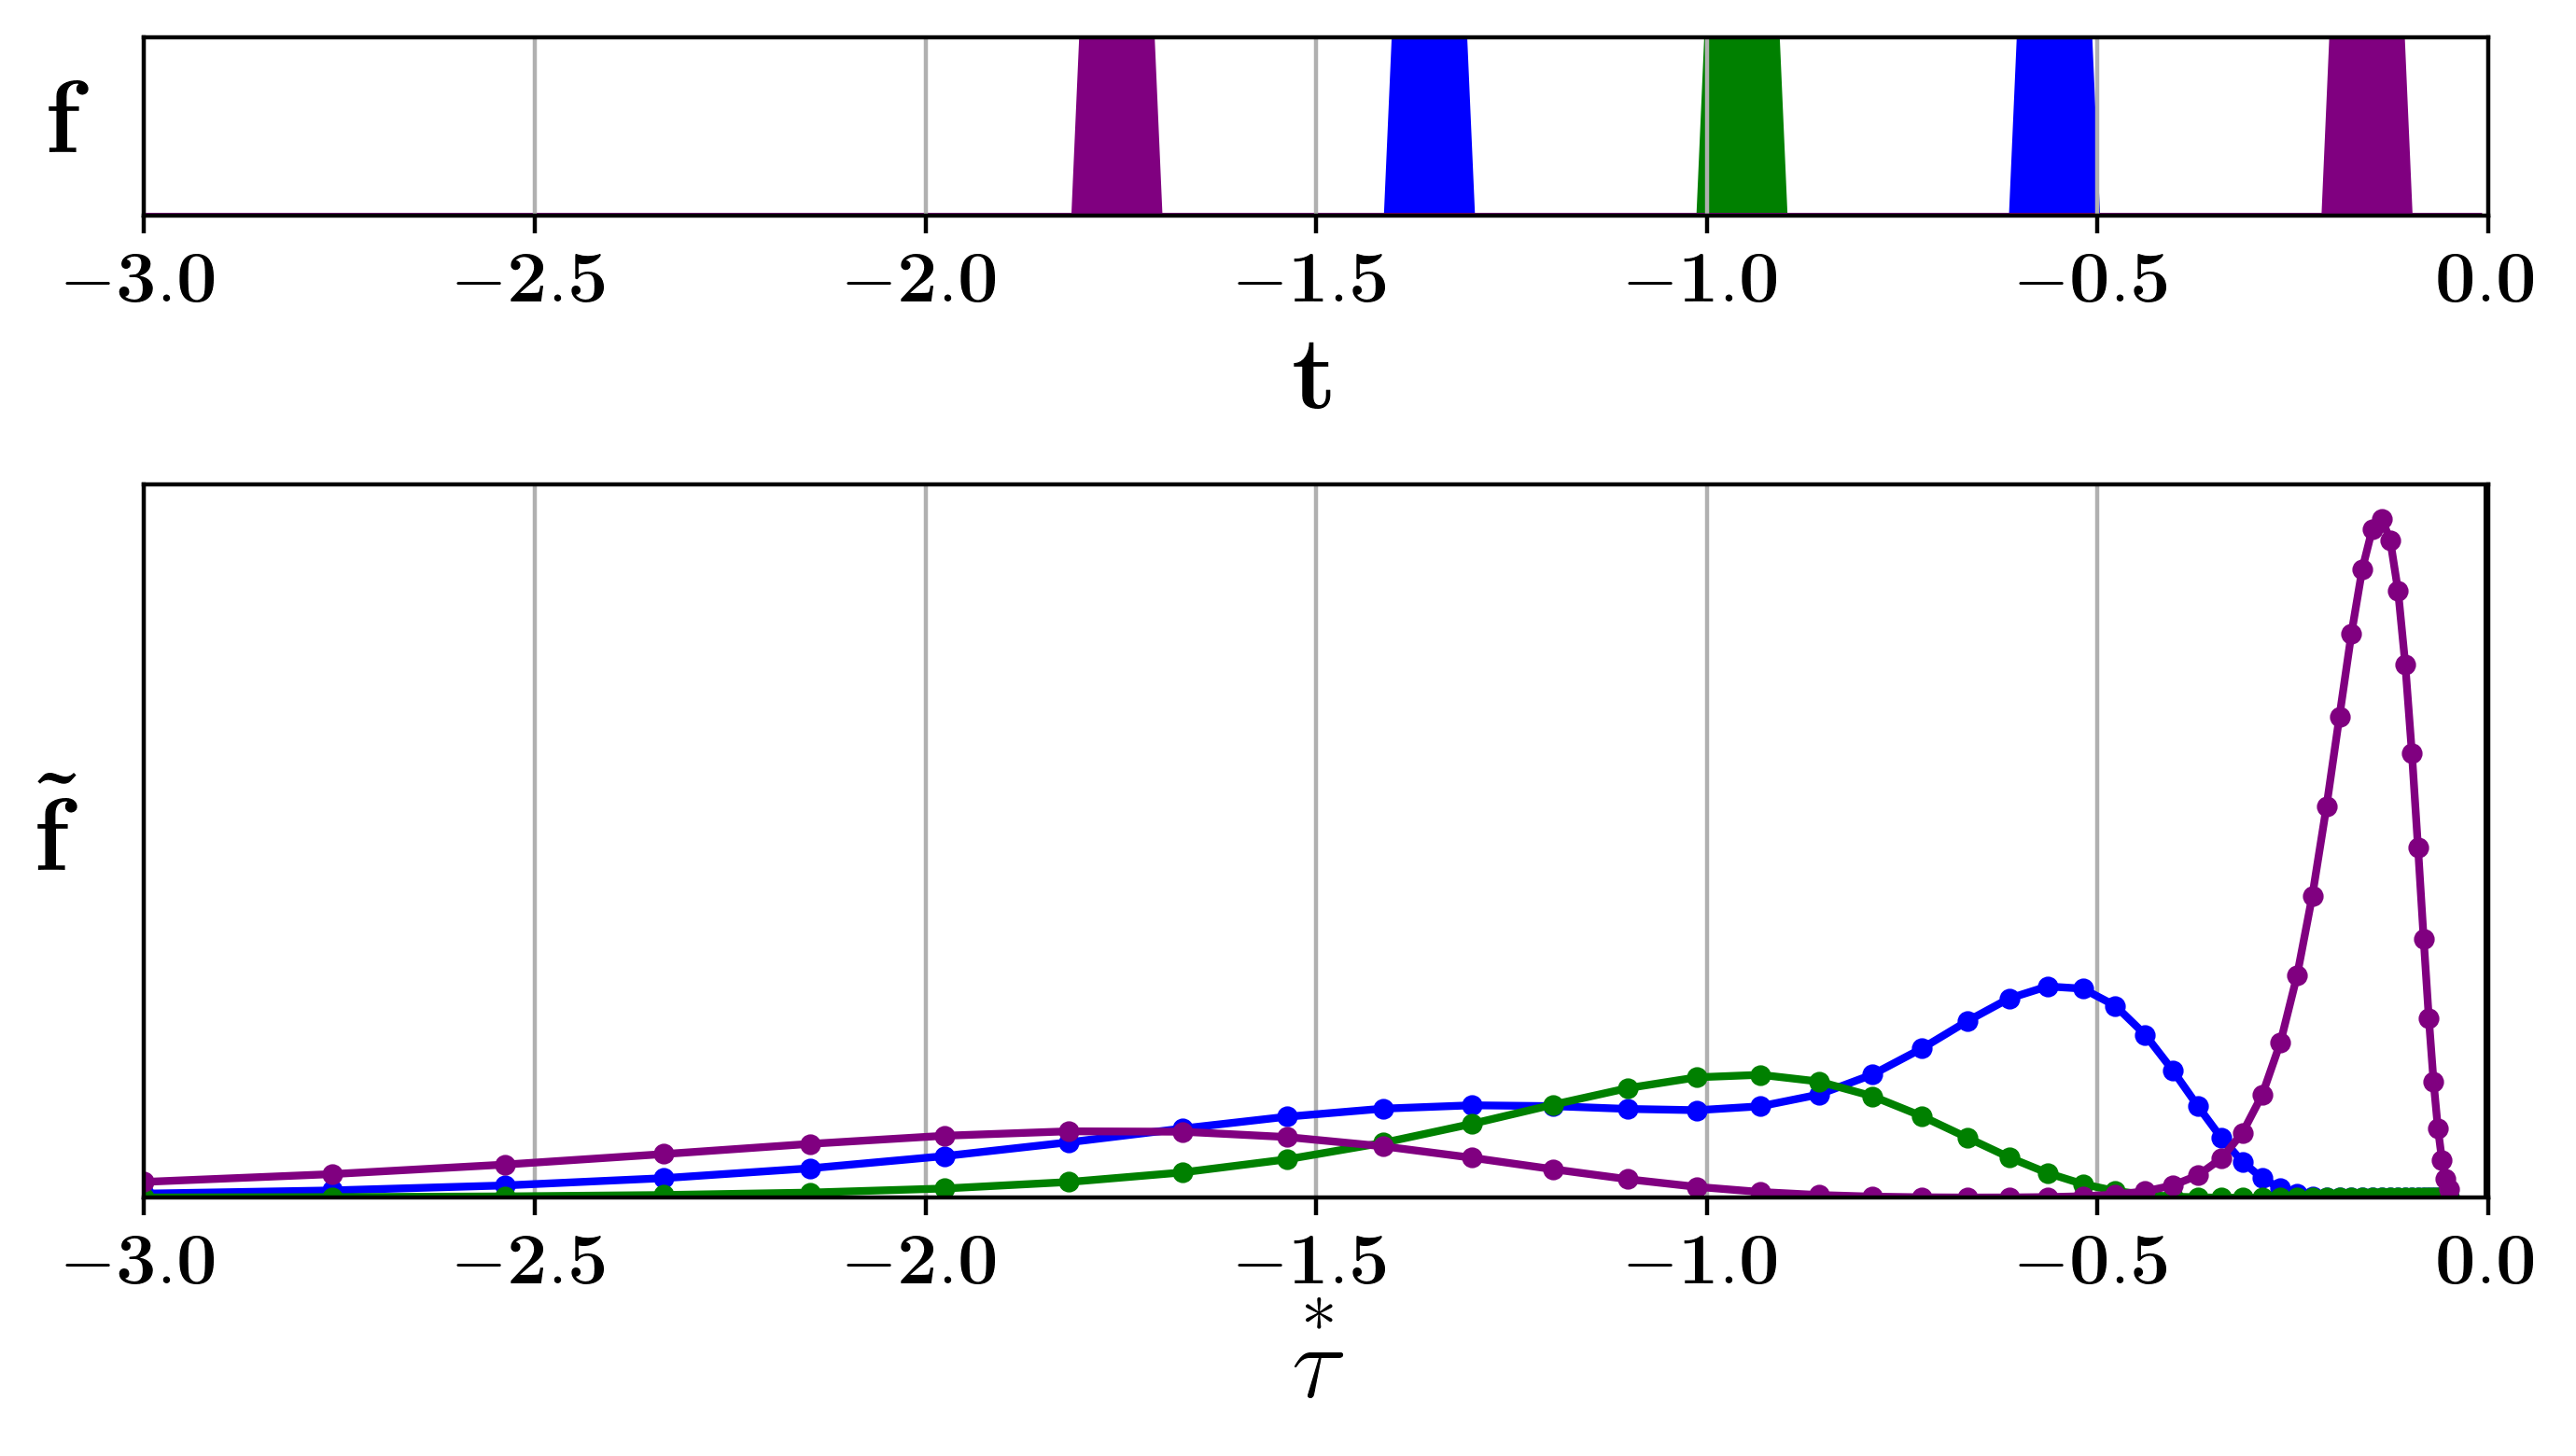

In [35]:
# Fig 1 - til_f

# reset hidden states
F = None
M = None
M_F = None

inputs2 = torch.zeros(Nt, n_features)  # (time, feat)

inputs2[360:370, Color.PURPLE] = 1  # P
inputs2[400:410, Color.BLUE] = 1     # B
inputs2[440:450, Color.GREEN] = 1   # G
inputs2[480:490, Color.BLUE] = 1    # B
inputs2[520:530, Color.PURPLE] = 1  # P

inputs2[840:850, Color.GREEN] = 1     # G
# inputs[880:890, Color.RED] = 1     # R
# inputs[920:930, Color.ORANGE] = 1  # O

inputs2 = inputs2.unsqueeze(0)  # add batch dimension

alphas = torch.full((1, 1, n_features), 1.5)  # correction factor, for approximation error with inverse transform

t = 540
steps = 1
for f in inputs2[:, :t, :].split(steps, dim=1):
    # f.shape = (batch, steps, n_features)
    til_f, F = WM_model(f, F, alphas=alphas)

til_f = til_f[-1]  # take last time step
x_tstr = WM_model.tau_stars

plot_figure(t, inputs2[0], til_f[0], None, x_tstr, rewind_secs=0, save_path=f"figures/til_f{savefile_suffix}.png")

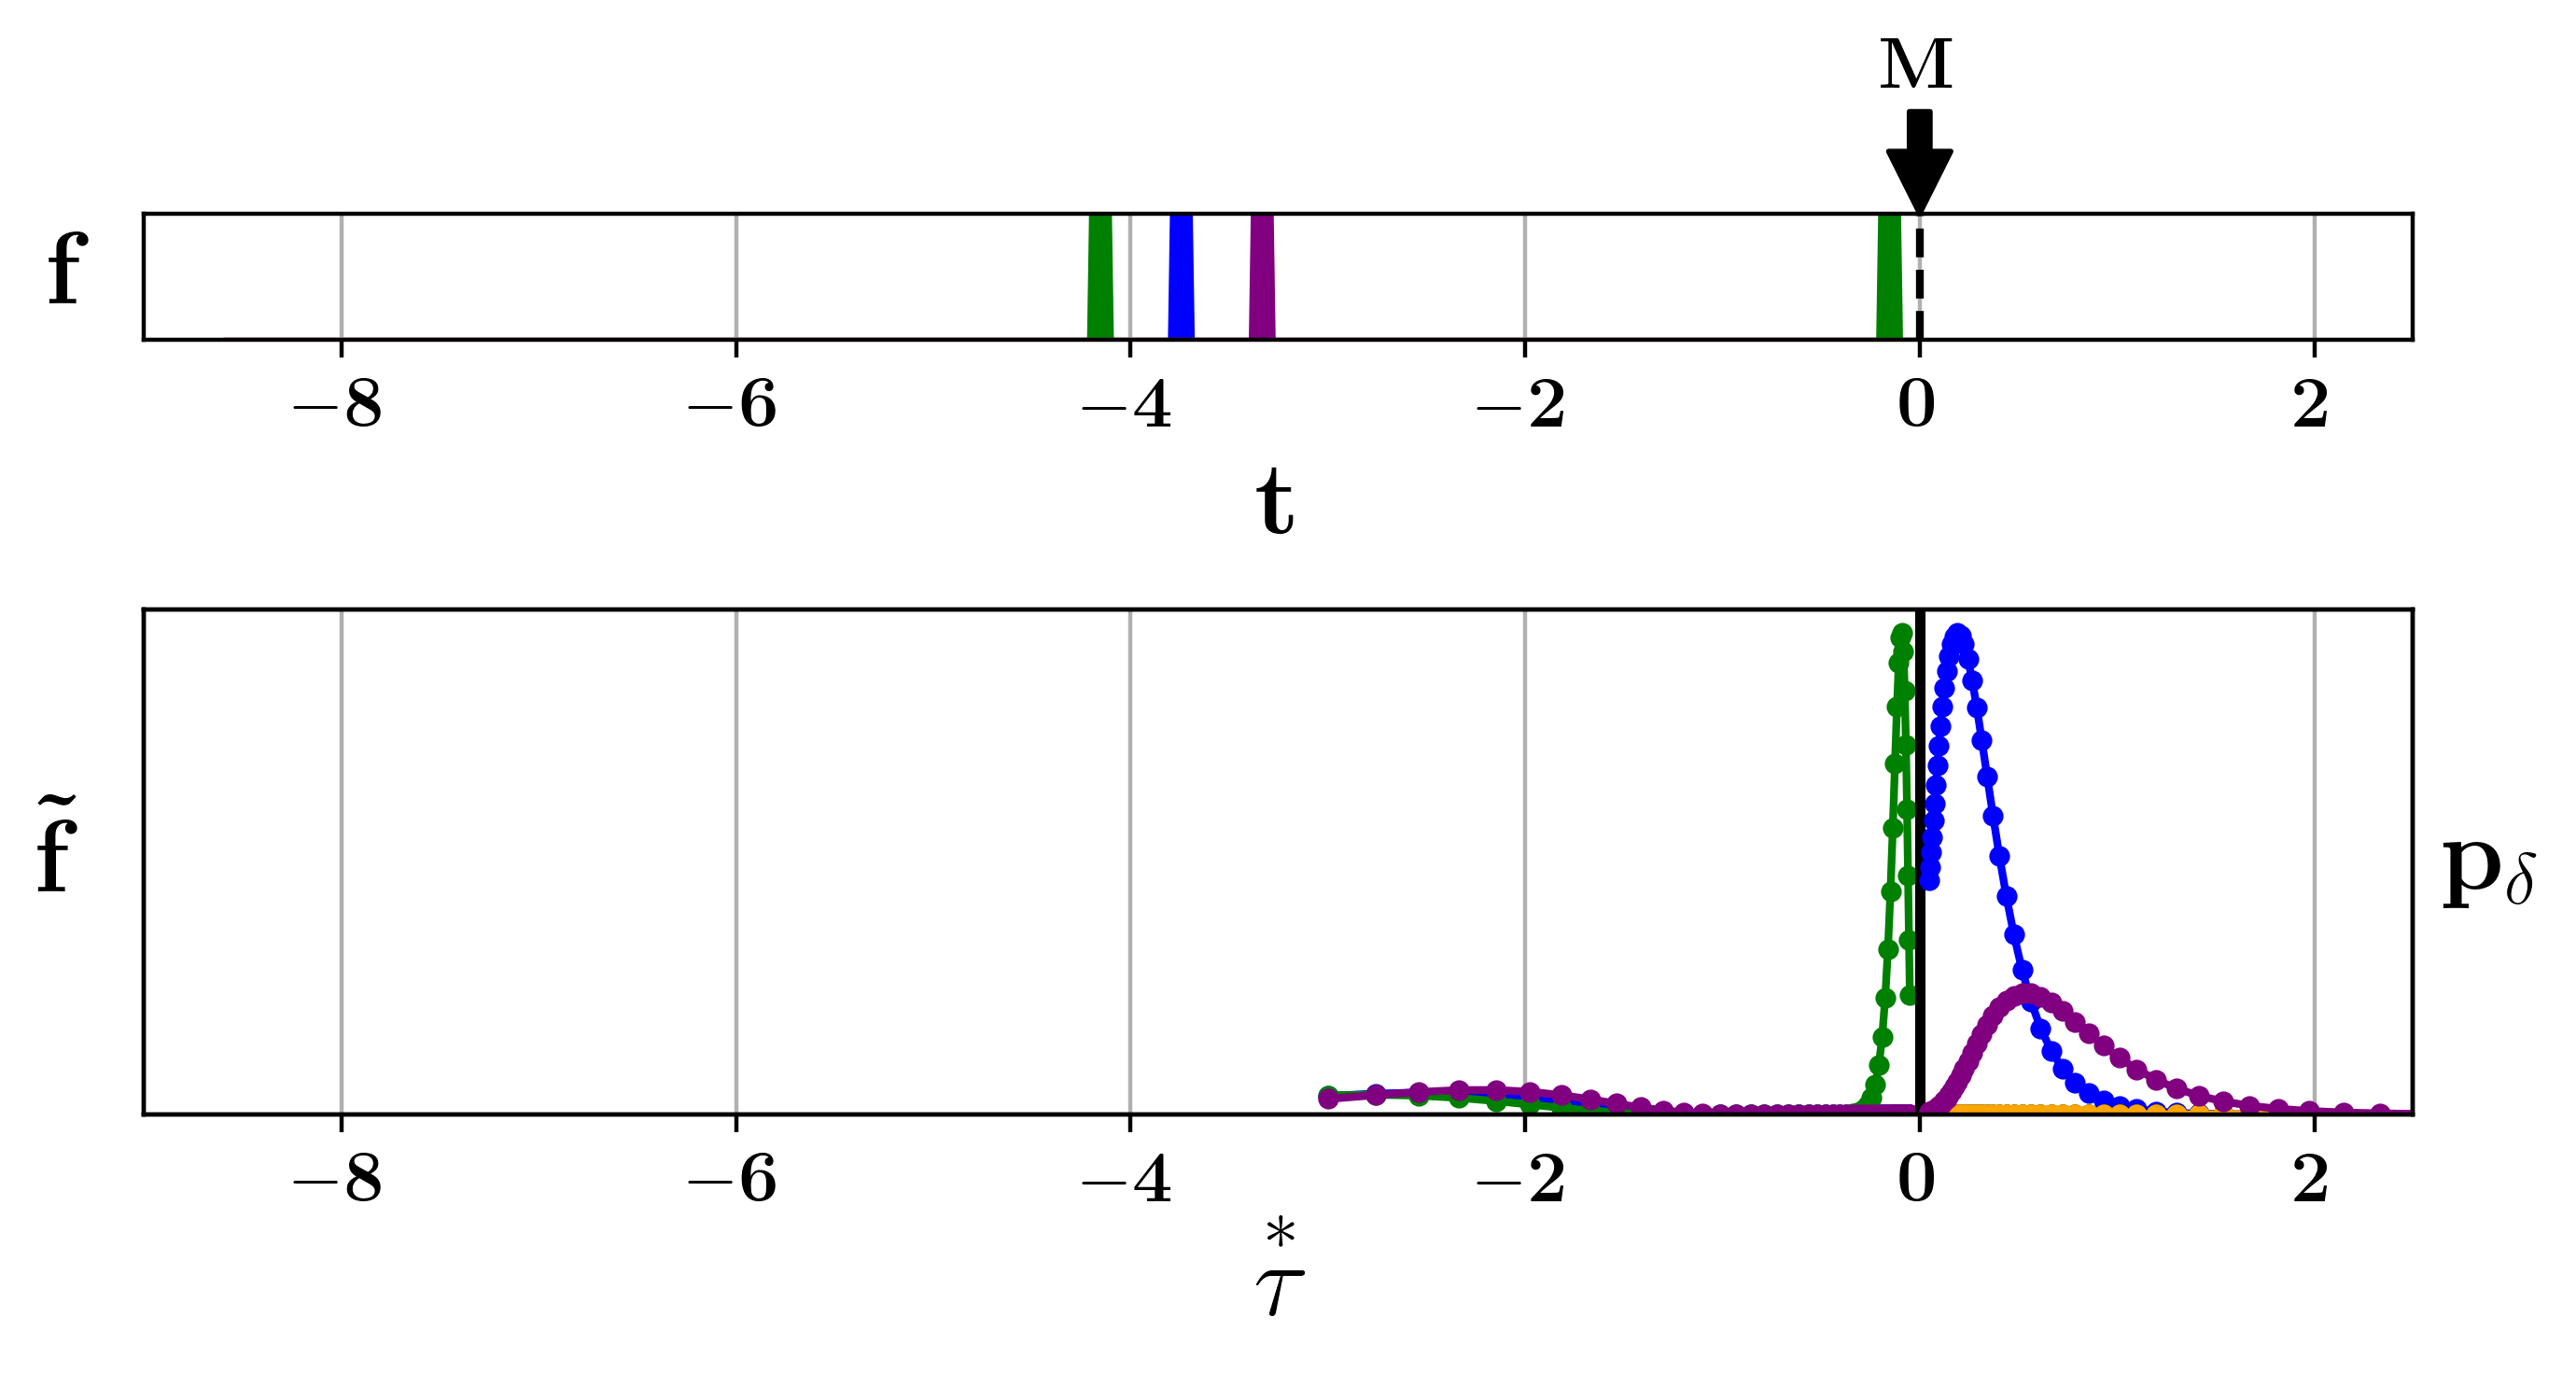

In [ ]:
# Fig 2 - M, first set of inputs not present

t1 = 860

# reset hidden states
F = None
M = None
M_F = None

inputs2 = inputs.clone()

inputs2[0, 40:130, :] = 0

alphas = torch.full((1, 1, n_features), 1.5)  # correction factor, for approximation error with inverse transform

steps = 1
for f in inputs2[:, :t1, :].split(steps, dim=1):
    # f.shape = (batch, steps, n_features)
    til_f, F = WM_model(f, F, alphas=alphas)
    
    # FIXME: EM_model should be able to handle batched inputs
    M, M_F = EM_model(f[0], til_f[0], M, M_F, A=lambdas)
    
til_f = til_f[-1]  # take last time step

delta_til_f = WM_model.get_translations(F)
delta_til_f = delta_til_f[0]  # 0th batch

P_delta = EM_model.get_P_delta(M, delta_til_f)
P_delta_sum = torch.einsum("dtf -> fd", P_delta)

x_tstr = WM_model.tau_stars
# batch 0
plot_figure(t1, inputs2[0], til_f[0], P_delta_sum, x_tstr, rewind_secs=0, save_path=f"figures/M_nofirst{savefile_suffix}.png")

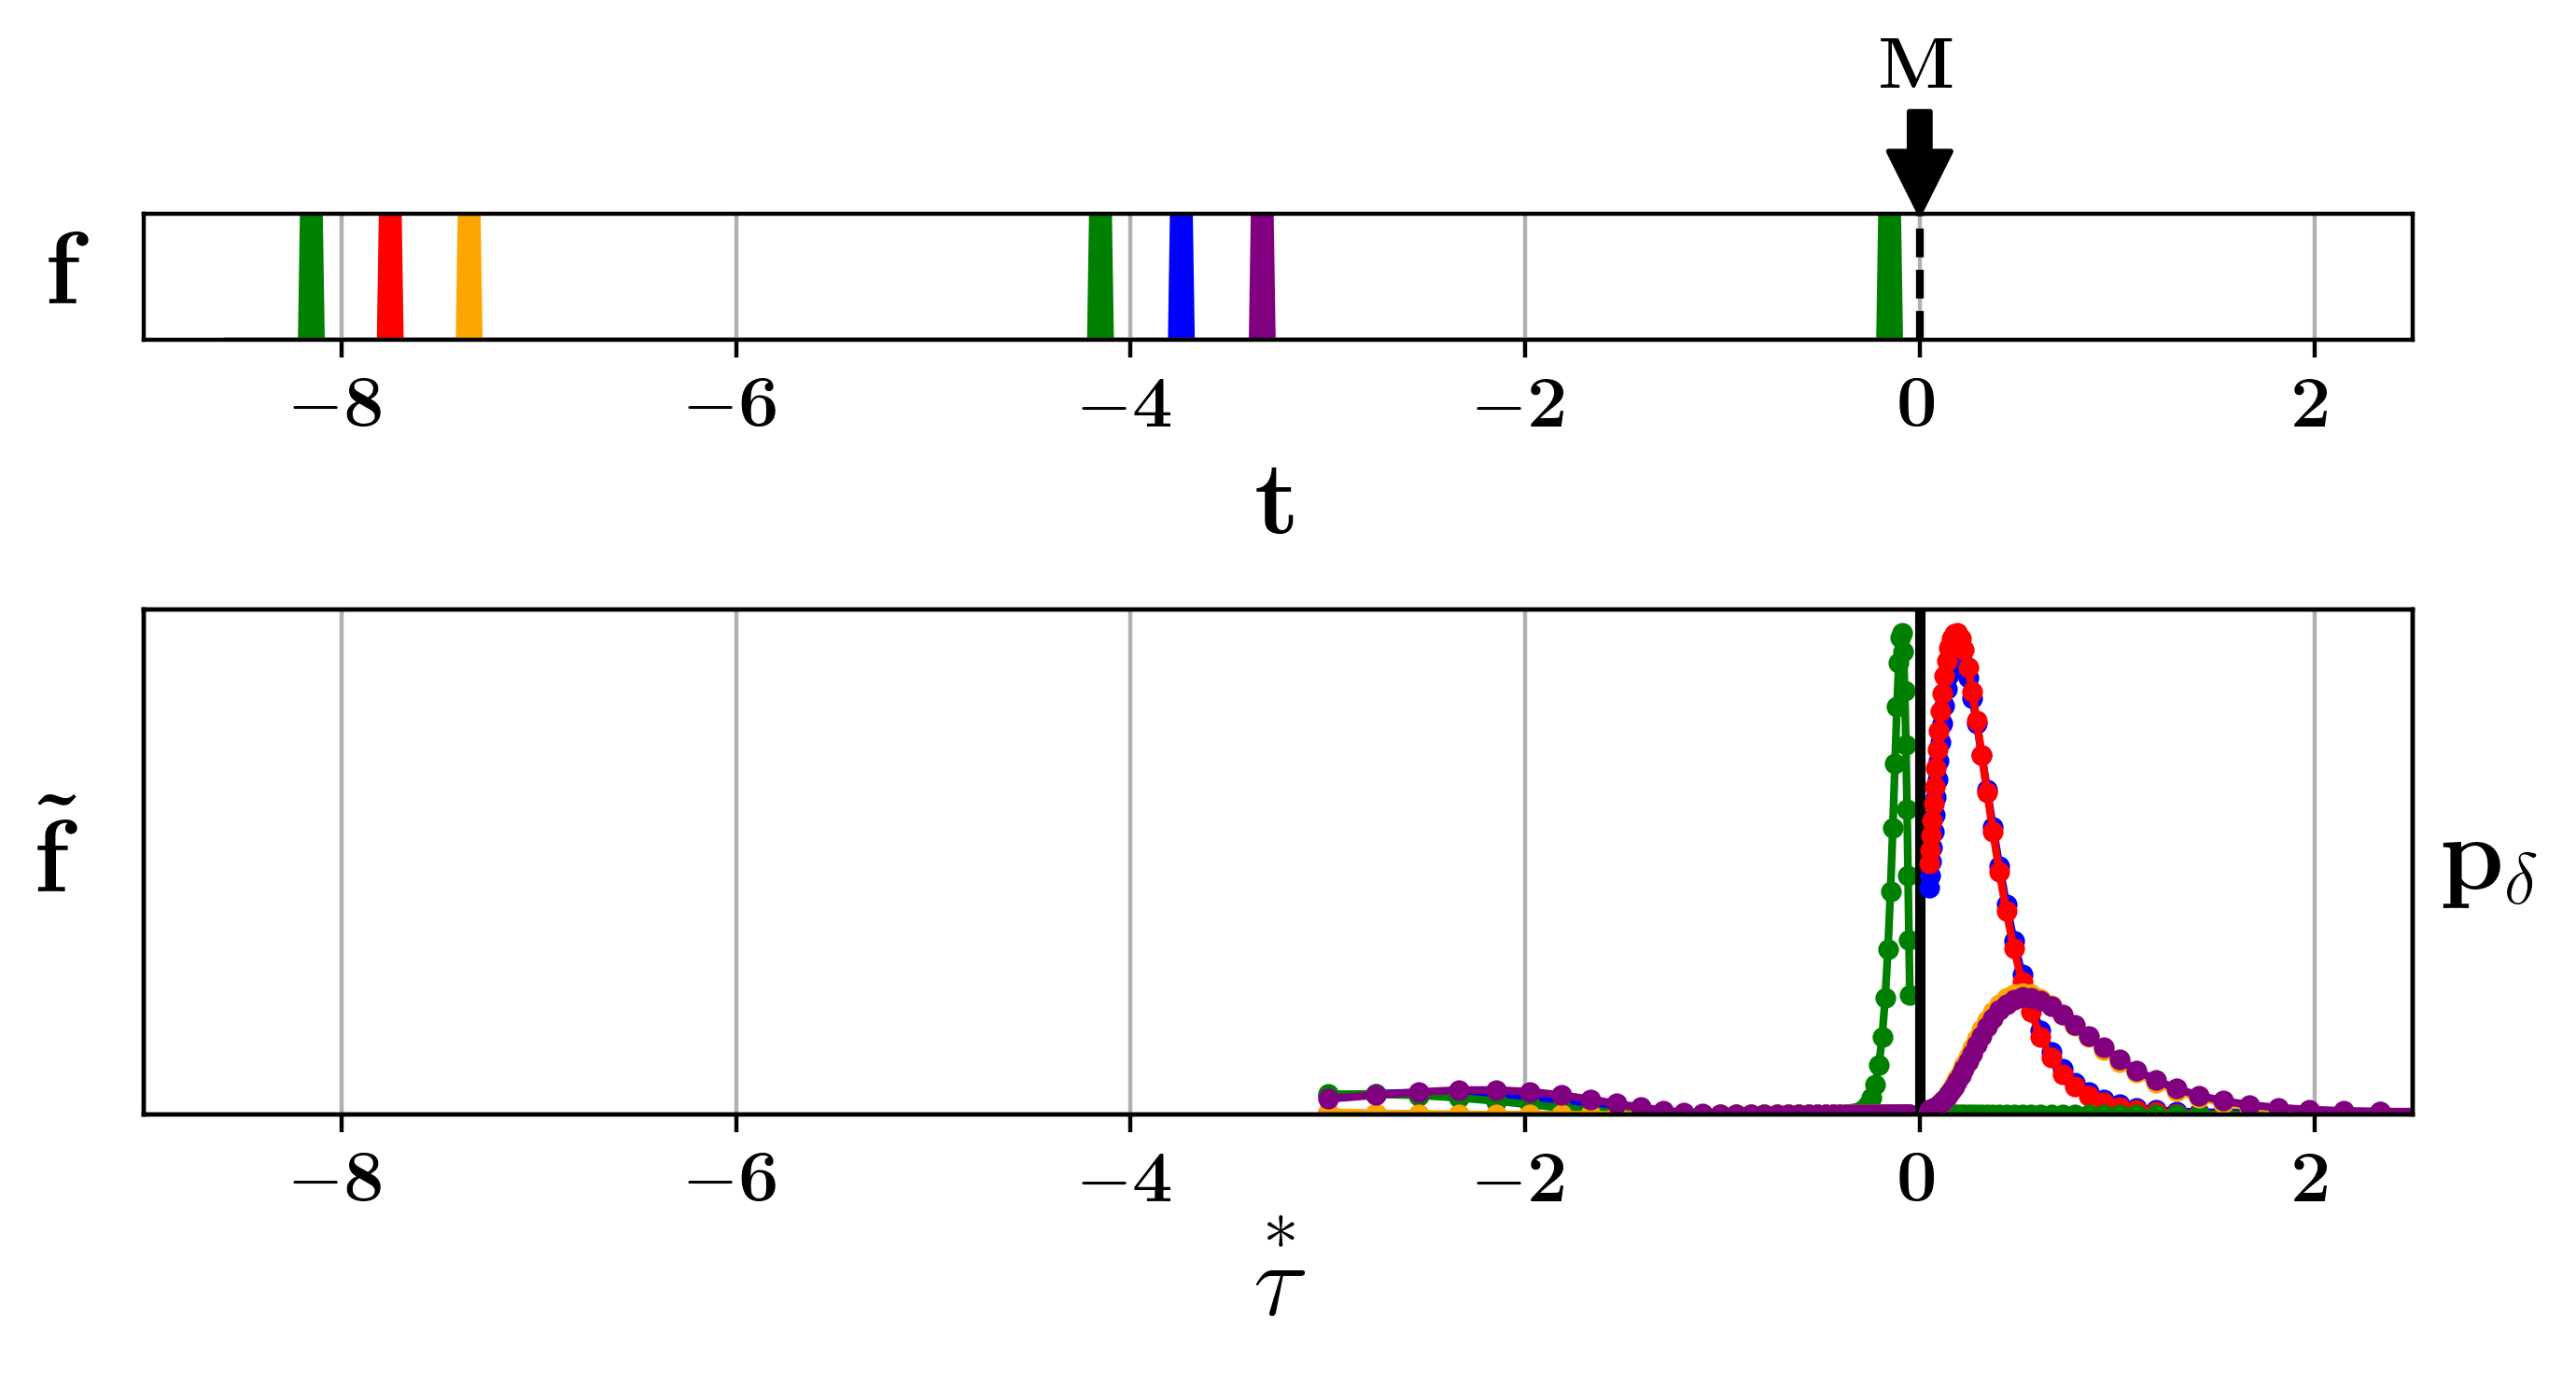

In [37]:
# Fig 3 - M, first set of inputs are present

t2 = 860

# reset hidden states
F = None
M = None
M_F = None

steps = 1
for f in inputs[:, :t2, :].split(steps, dim=1):
    til_f, F = WM_model(f, F, alphas=alphas)
    
    # FIXME: EM_model should be able to handle batched inputs
    M, M_F = EM_model(f[0], til_f[0], M, M_F, A=lambdas)
    
til_f = til_f[-1]

delta_til_f = WM_model.get_translations(F)
delta_til_f = delta_til_f[0]  # 0th batch

P_delta = EM_model.get_P_delta(M, delta_til_f)
P_delta_sum = torch.einsum("dtf -> fd", P_delta)

plot_figure(t2, inputs[0], til_f[0], P_delta_sum, x_tstr, rewind_secs=0, save_path=f"figures/M_first{savefile_suffix}.png")

Reconstructing memory from 715.44 steps ago.
Simulated M is at timestep 144.56


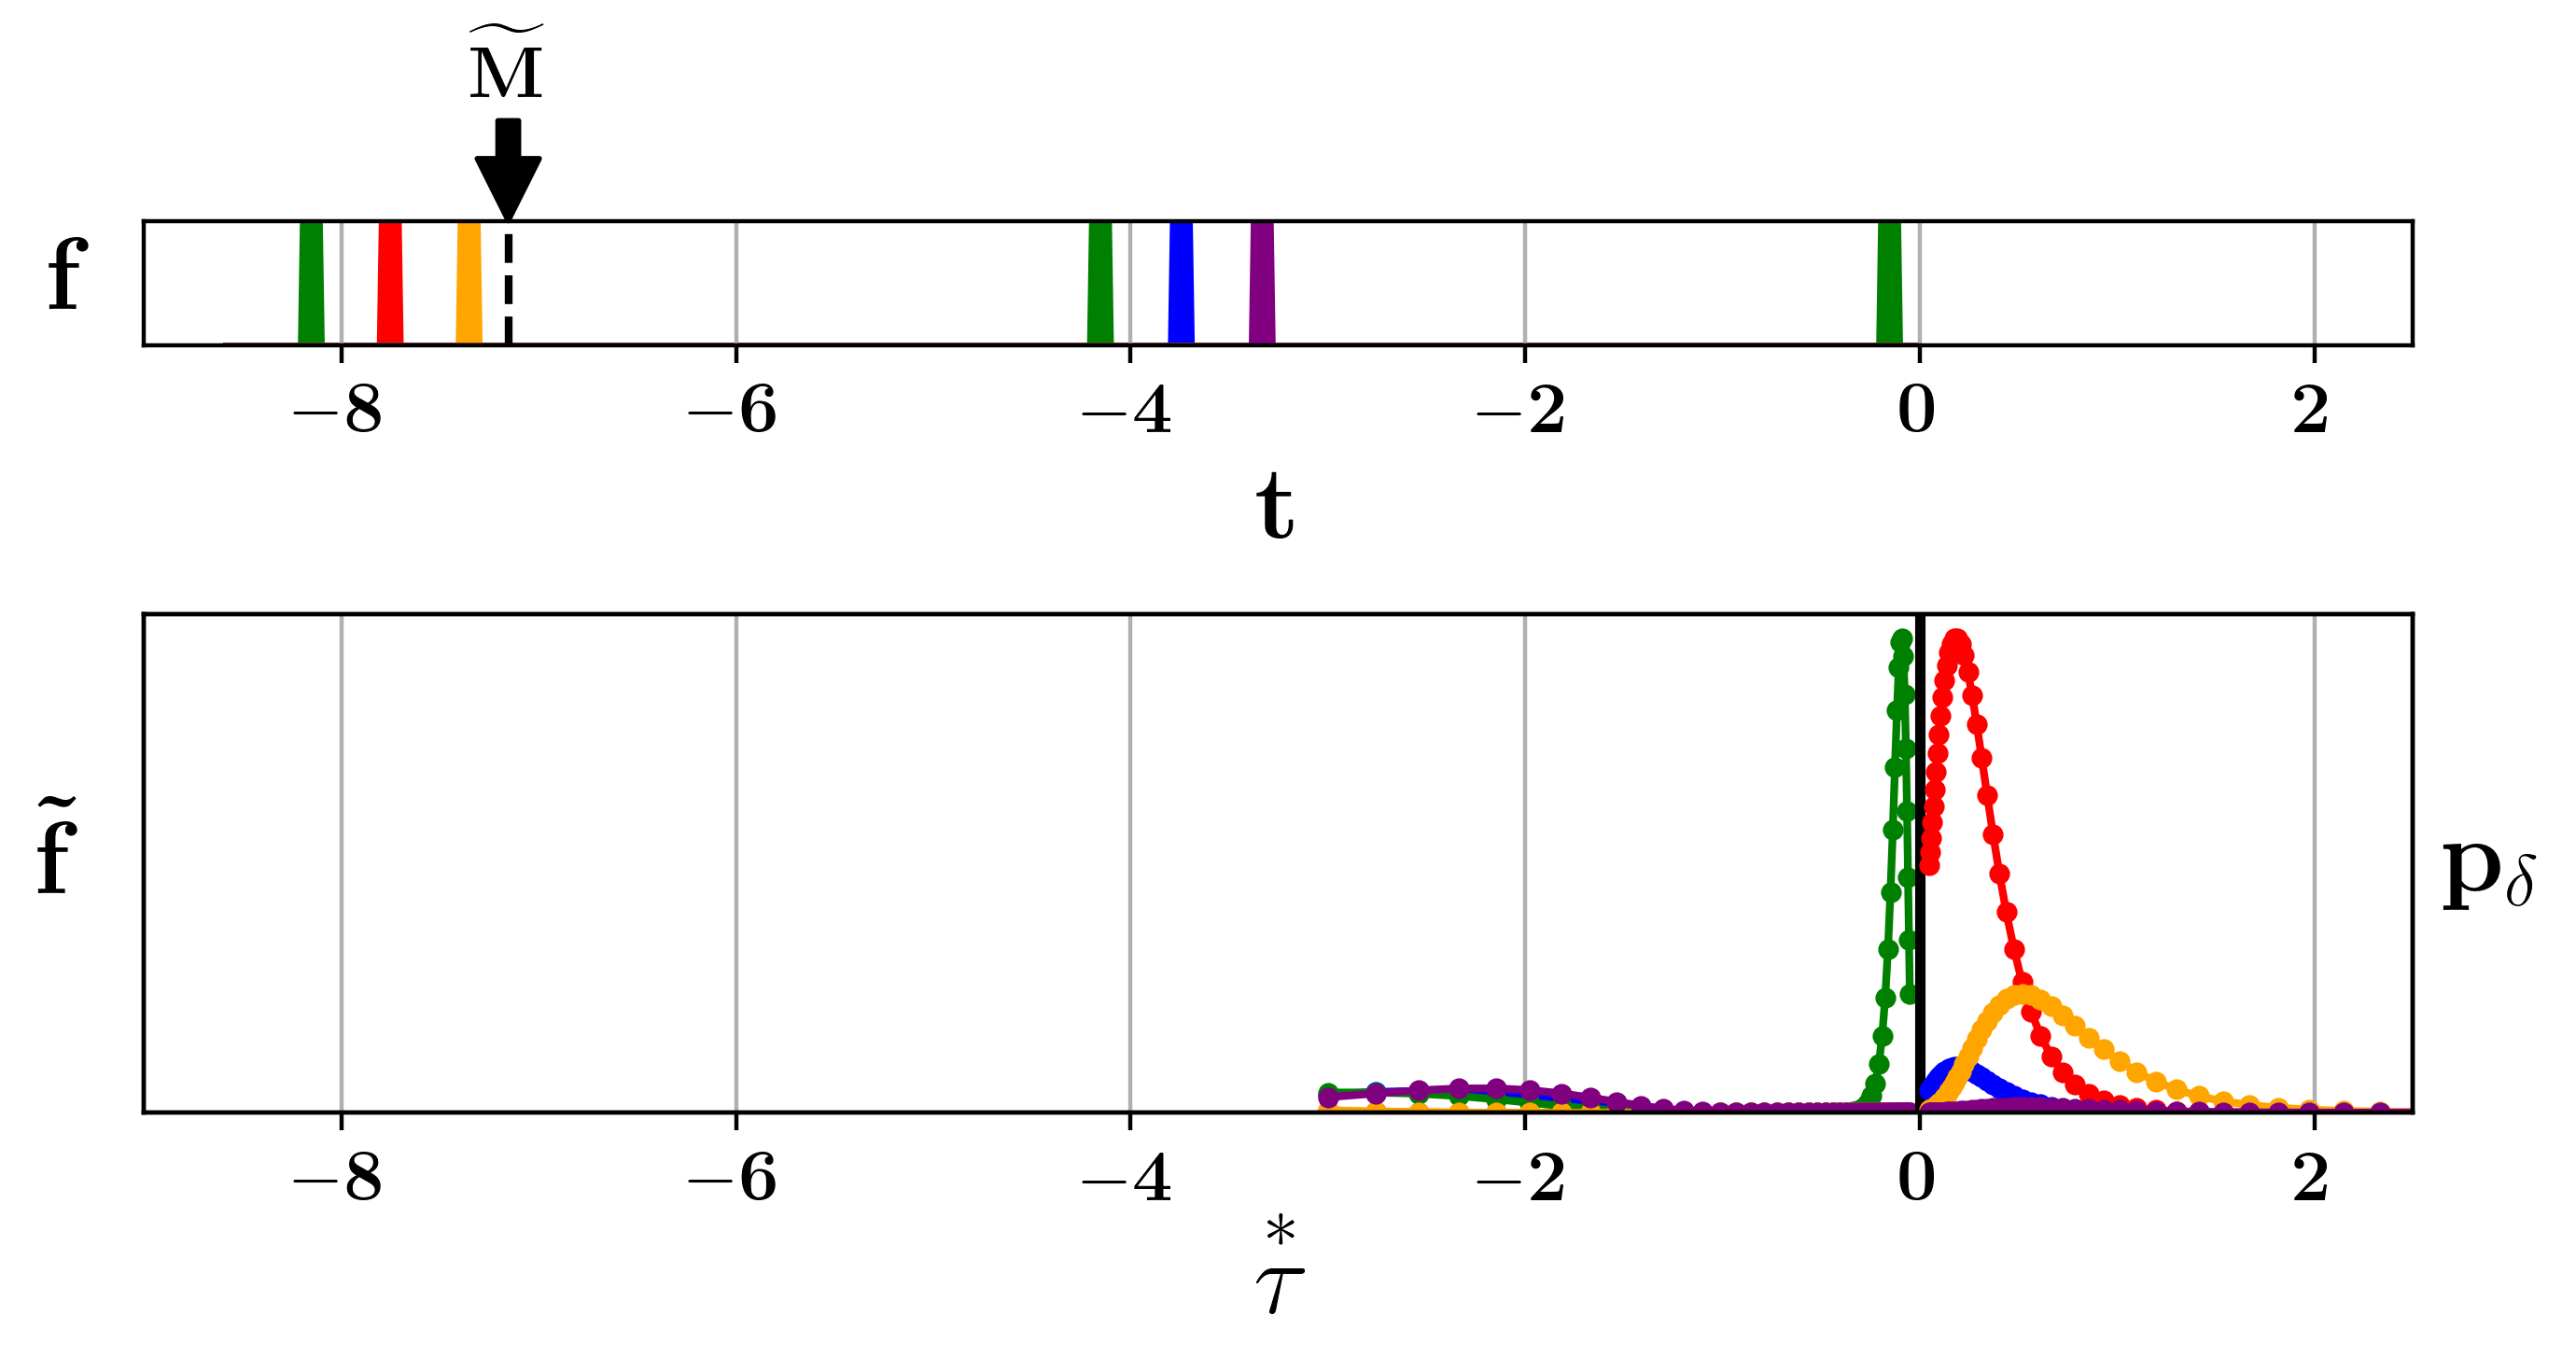

In [38]:
# Fig 4 - til_M, pointer at first set of inputs

rewind_target = 720
rewind_idx = (EM_model.M_model.tau_stars - rewind_target).abs().argmin()

til_M_t = EM_model.til_M[rewind_idx]
rewind_secs = M_model.tau_stars[rewind_idx]

print(f"Reconstructing memory from {rewind_secs:.2f} steps ago.")
print(f"Simulated M is at timestep {t2 - rewind_secs:.2f}")

P_delta = EM_model.get_P_delta(til_M_t, delta_til_f)
P_delta_sum = torch.einsum("dtf -> fd", P_delta)

plot_figure(t2, inputs[0], til_f[0], P_delta_sum, x_tstr, rewind_secs=rewind_secs, save_path=f"figures/tilM_first{savefile_suffix}.png")

Reconstructing memory from 307.78 steps ago.
Simulated M is at timestep 552.22


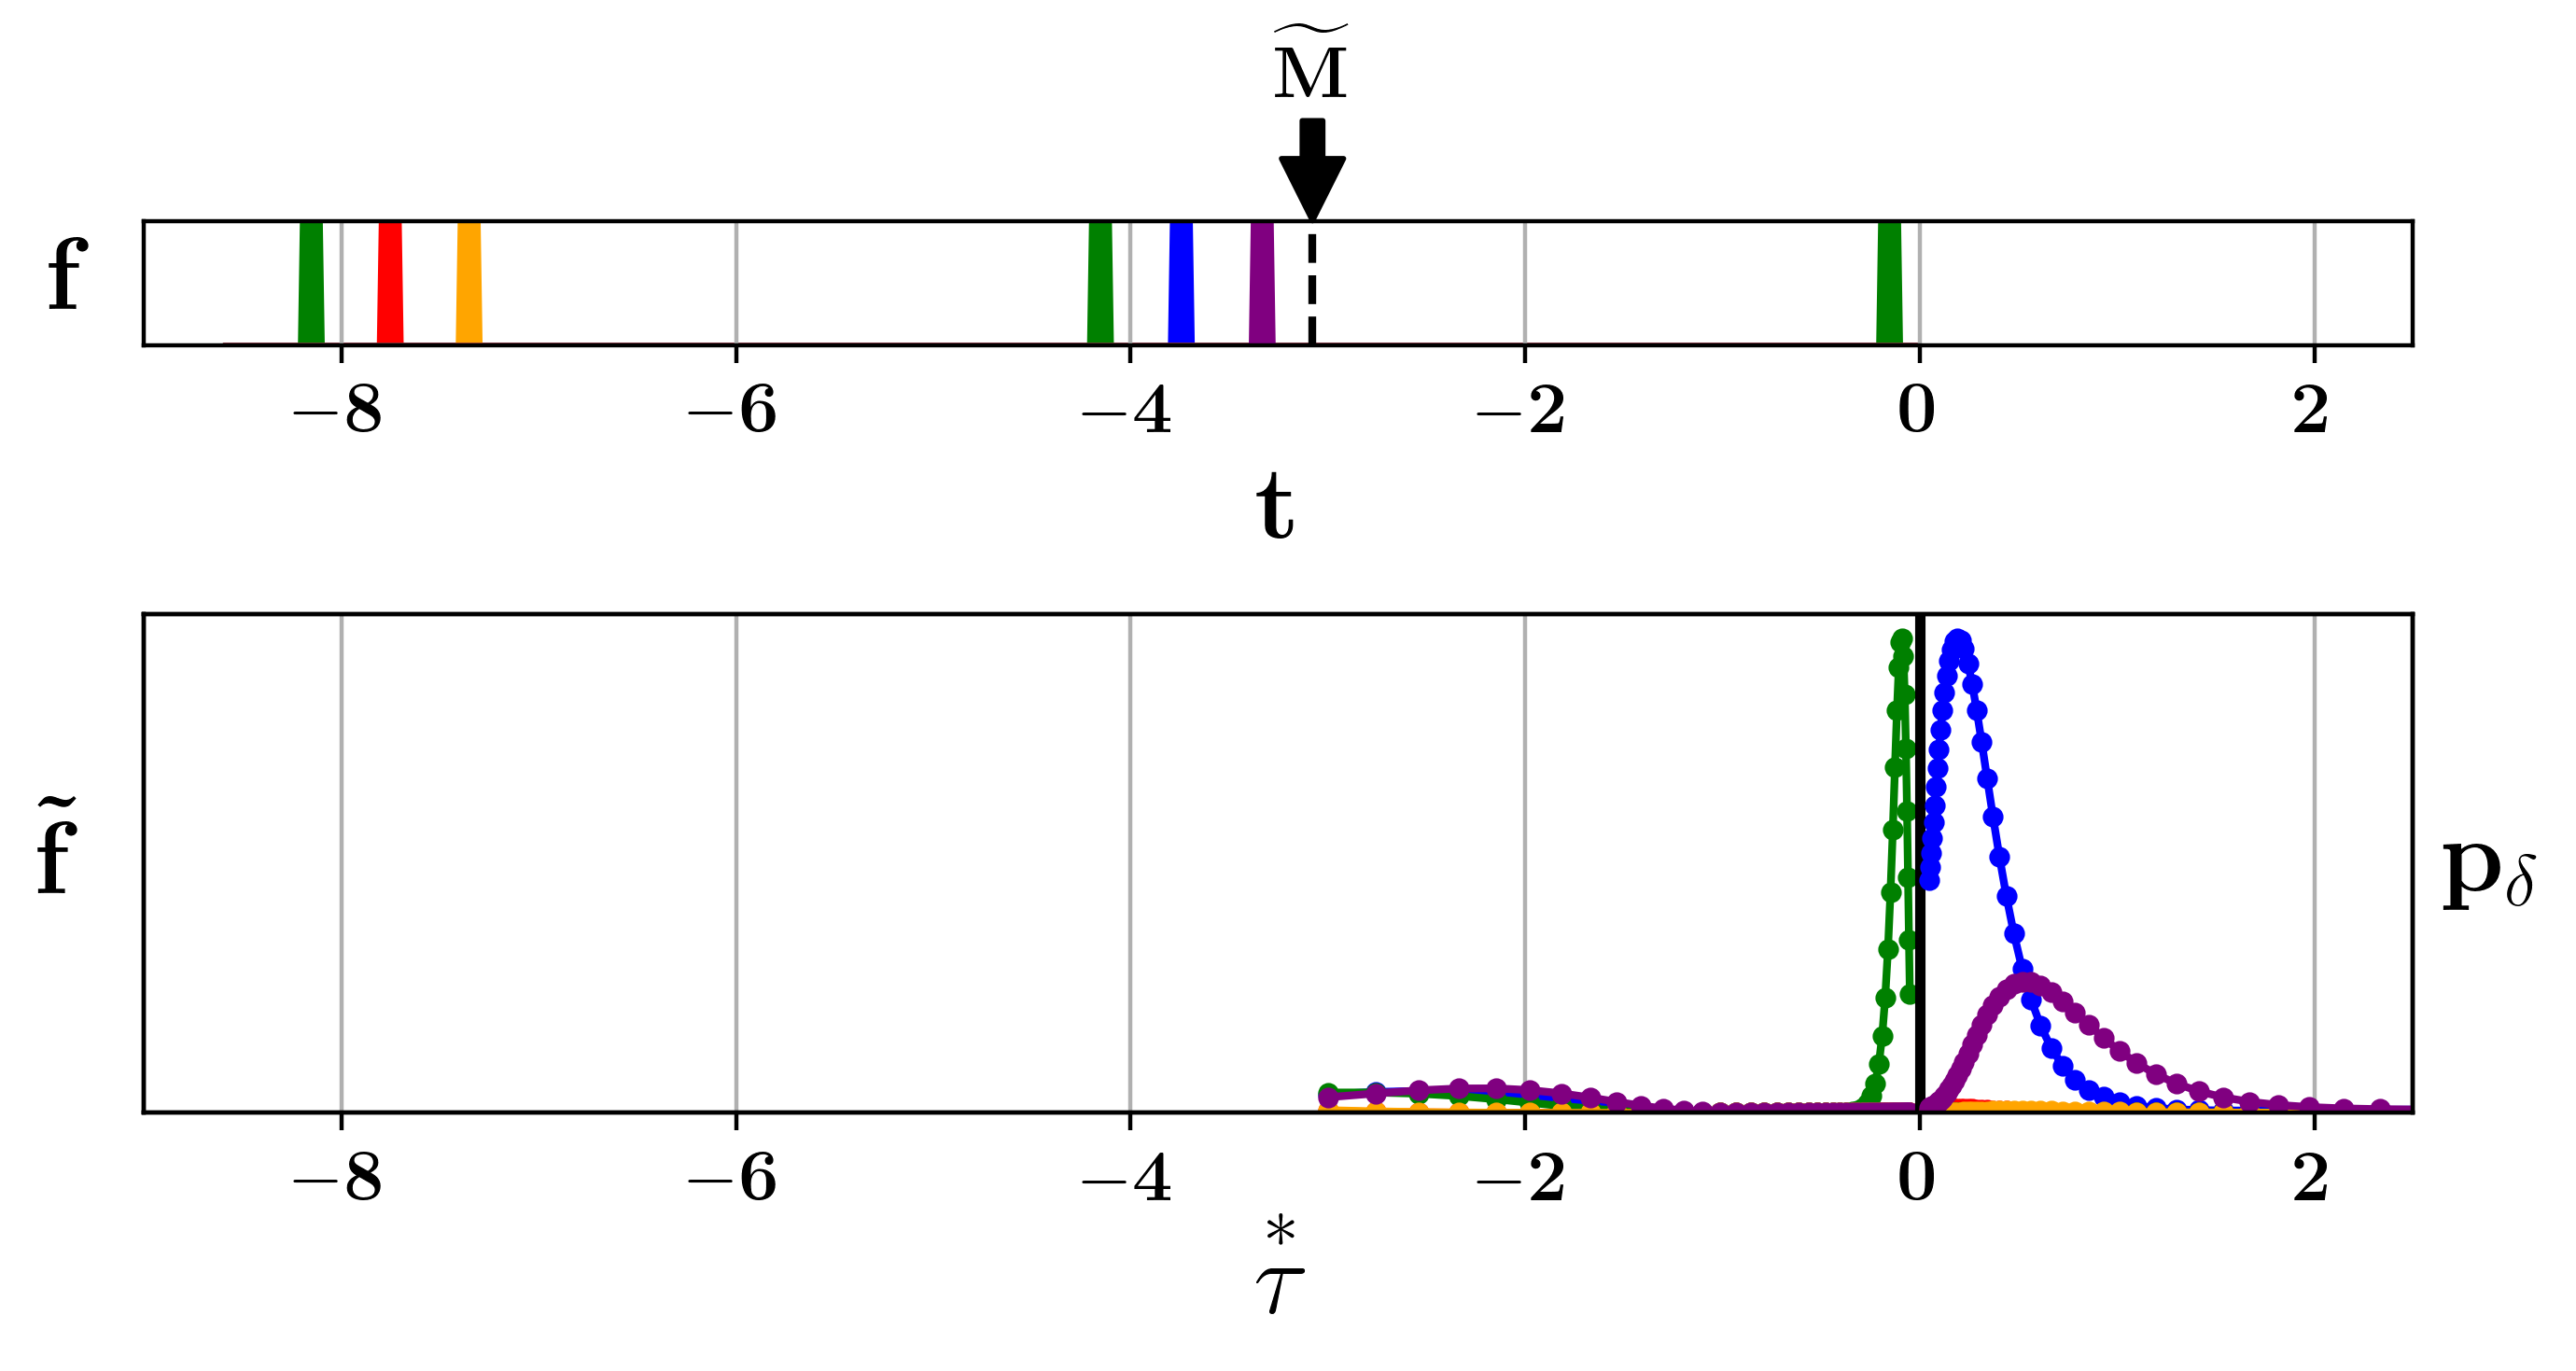

In [39]:
# Fig 5 - til_M, pointer at second set of inputs

rewind_target = 310
rewind_idx = (EM_model.M_model.tau_stars - rewind_target).abs().argmin()

til_M_t = EM_model.til_M[rewind_idx]
rewind_secs = M_model.tau_stars[rewind_idx]

print(f"Reconstructing memory from {rewind_secs:.2f} steps ago.")
print(f"Simulated M is at timestep {t2 - rewind_secs:.2f}")

P_delta = EM_model.get_P_delta(til_M_t, delta_til_f)
P_delta_sum = torch.einsum("dtf -> fd", P_delta)

plot_figure(t2, inputs[0], til_f[0], P_delta_sum, x_tstr, rewind_secs=rewind_secs, save_path=f"figures/tilM_second{savefile_suffix}.png")